# Imports, downloads, etc.

In [0]:
import requests
import nltk
from bs4 import BeautifulSoup


# Creating the dataframe from csv

In [59]:
import pandas as pd
#pd.set_option('display.max_colwidth', none)
url_file = 'https://raw.githubusercontent.com/MarissaFosse/ryersoncapstone/master/DailyNewsArticlesCSV.csv'

tstar_articles = pd.read_csv(url_file, header=0, usecols=["Date", "Category", "Publisher", "Heading", "URL"]) 

#tstar_articles.describe()
tstar_articles.head(90)

,Date,Category,Publisher,Heading,URL
0,2020-01-01,Violent Crime,The Star,"With 292 people shot, 2019 comes to a close as...",https://www.thestar.com/news/gta/2019/12/31/wi...
1,2020-01-01,Violent Crime,The Star,Two men shot overnight in North York,https://www.thestar.com/news/crime/2019/12/31/...
2,2020-01-01,Violent Crime,The Star,Six arrested after downtown home invasion on B...,https://www.thestar.com/news/gta/2019/12/31/si...
3,2020-01-04,Violent Crime,The Star,Toronto police ID last homicide victim of 2019...,https://www.thestar.com/news/crime/2020/01/02/...
4,2020-01-04,Traffic,The Star,SIU clears police after a car they initially c...,https://www.thestar.com/news/gta/2020/01/02/si...
...,...,...,...,...,...
85,2020-02-05,Missing Persons,The Star,Homicide victim Tess Richey’s friend describes...,https://www.thestar.com/news/gta/2020/02/04/te...
86,2020-02-06,Violent Crime,The Star,Scarborough’s Cedarbrae Collegiate Institute l...,https://www.thestar.com/news/gta/2020/02/05/sc...
87,2020-02-06,Missing Persons,The Star,Undercover cops discussed Magic: The Gathering...,https://www.thestar.com/news/gta/2020/02/05/un...
88,2020-02-07,Violent Crime,The Star,Man sustains ‘life-altering’ injuries after he...,https://www.thestar.com/news/gta/2020/02/06/ma...


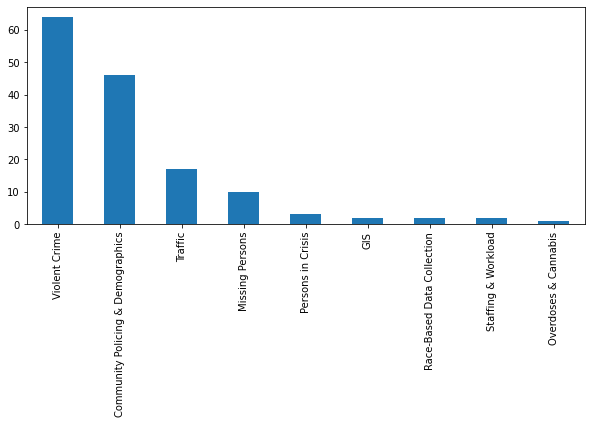

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
tstar_articles.Category.value_counts().plot(kind='bar')

The categories are not well balanced. Thus, my classification algorithm will be designed to only predict Violent Crime and Community Policing & Demographics. Perhaps Traffic if I normalize the data. 

# Creating a list of the tokenized/lemmatized words from each artile and appending it to the dataframe

In [0]:
url_to_sents = {}

for url in tstar_articles['URL']:
    response = requests.get(url)
    bsoup = BeautifulSoup(response.content.decode('utf8'))
    if bsoup.find(class_='c-article-body__content'):
      article_sents = ' '.join([p.text for p in bsoup.find(class_='c-article-body__content').find_all('p')])
    url_to_sents[url] = article_sents

In [0]:
#url_to_sents

Append the extracted text to the tstar_articles dataframe.

In [126]:
urls, texts = zip(*url_to_sents.items())
data = {'urls':urls, 'text':texts}
df1 = pd.DataFrame.from_dict(data)

tstar_articles['raw text'] = df1['text']
tstar_articles.head()

,level_0,index,Date,Category,Publisher,Heading,URL,PortfolioId,raw text
0,0,0,2020-01-01,Violent Crime,The Star,"With 292 people shot, 2019 comes to a close as...",https://www.thestar.com/news/gta/2019/12/31/wi...,8,Toronto’s bloodiest year for gun violence is c...
1,1,1,2020-01-01,Violent Crime,The Star,Two men shot overnight in North York,https://www.thestar.com/news/crime/2019/12/31/...,8,Toronto police are investigating after a 24-ye...
2,2,2,2020-01-01,Violent Crime,The Star,Six arrested after downtown home invasion on B...,https://www.thestar.com/news/gta/2019/12/31/si...,8,Six people have been arrested following a viol...
3,3,3,2020-01-04,Violent Crime,The Star,Toronto police ID last homicide victim of 2019...,https://www.thestar.com/news/crime/2020/01/02/...,8,Toronto police have identified the city’s last...
4,4,4,2020-01-04,Traffic,The Star,SIU clears police after a car they initially c...,https://www.thestar.com/news/gta/2020/01/02/si...,7,"It started in a Scarborough plaza, when Toront..."


In [127]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import random
from string import punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


For stop words, I used both the NLTK English stopwords, the stopwords-json from https://github.com/6/stopwords-json, and I created my own list specific to law enforcement.

In [0]:
stopwords_nltk = set(stopwords.words('english')) | set(punctuation)
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_police = ["a.m.","p.m.","near","“","”","’","police","officer","toronto","say","also","year"]
stoplist_combined = set.union(stopwords_nltk, stopwords_json, stopwords_police)

In [129]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
wnl = WordNetLemmatizer()

def penn2morphy(penntag):
  morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
  try:
    return morphy_tag[penntag[:2]]
  except:
    return 'n'

def lemmatize_sent(text):
  return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(word_tokenize(text))]

In [0]:
def preprocess_text(text):
  return [word for word in lemmatize_sent(text) if word not in stoplist_combined and not word.isdigit()]

In [0]:
tstar_articles['Cleaned_Tokens'] = tstar_articles['raw text'].apply(preprocess_text)

In [0]:
tstar_articles['Cleaned_Text']=[" ".join(words) for words in tstar_articles['Cleaned_Tokens'].values]

In [134]:
tstar_articles.head(20)

,level_0,index,Date,Category,Publisher,Heading,URL,PortfolioId,raw text,Cleaned_Tokens,Cleaned_Text
0,0,0,2020-01-01,Violent Crime,The Star,"With 292 people shot, 2019 comes to a close as...",https://www.thestar.com/news/gta/2019/12/31/wi...,8,Toronto’s bloodiest year for gun violence is c...,"[bloody, gun, violence, come, close, start, ea...",bloody gun violence come close start early jan...
1,1,1,2020-01-01,Violent Crime,The Star,Two men shot overnight in North York,https://www.thestar.com/news/crime/2019/12/31/...,8,Toronto police are investigating after a 24-ye...,"[investigate, 24-year-old, man, 17-year-old, b...",investigate 24-year-old man 17-year-old boy fi...
2,2,2,2020-01-01,Violent Crime,The Star,Six arrested after downtown home invasion on B...,https://www.thestar.com/news/gta/2019/12/31/si...,8,Six people have been arrested following a viol...,"[six, people, arrest, follow, violent, home, i...",six people arrest follow violent home invasion...
3,3,3,2020-01-04,Violent Crime,The Star,Toronto police ID last homicide victim of 2019...,https://www.thestar.com/news/crime/2020/01/02/...,8,Toronto police have identified the city’s last...,"[identify, city, last, homicide, victim, man, ...",identify city last homicide victim man shot sc...
4,4,4,2020-01-04,Traffic,The Star,SIU clears police after a car they initially c...,https://www.thestar.com/news/gta/2020/01/02/si...,7,"It started in a Scarborough plaza, when Toront...","[start, scarborough, plaza, go, question, pass...",start scarborough plaza go question passenger ...
5,5,5,2020-01-05,Traffic,The Star,Man dead following hit-and-run at Jarvis and G...,https://www.thestar.com/news/gta/2020/01/04/ma...,7,A 65-year-old man has died after being struck ...,"[65-year-old, man, die, strike, driver, vehicl...",65-year-old man die strike driver vehicle jarv...
6,6,6,2020-01-07,Community Policing & Demographics,The Star,Mornelle Court residents took ‘our community b...,https://www.thestar.com/news/gta/2020/01/06/mo...,0,When Angela Brackett convinced her Mornelle Co...,"[angela, brackett, convince, mornelle, court, ...",angela brackett convince mornelle court neighb...
7,7,7,2020-01-07,Community Policing & Demographics,The Star,Do you recognize this dog? She was found zippe...,https://www.thestar.com/news/gta/2020/01/06/do...,0,Toronto police are appealing for more informat...,"[appeal, information, dog, find, abandon, zip,...",appeal information dog find abandon zip shut s...
8,8,8,2020-01-07,Community Policing & Demographics,The Star,City hall security upgrades could include meta...,https://www.thestar.com/news/gta/2020/01/06/ci...,0,Public access to Toronto City Hall could soon ...,"[public, access, city, hall, could, soon, incl...",public access city hall could soon include wal...
9,9,9,2020-01-07,Race-Based Data Collection,The Star,Black youth more likely to be charged and less...,https://www.thestar.com/news/gta/2020/01/06/bl...,5,Young Black people were less likely than white...,"[young, black, people, less, likely, white, yo...",young black people less likely white youth col...


In [135]:
tstar_articles['raw text'].apply(lambda x: len(x.split(' '))).sum()

78475

In [136]:
tstar_articles['Cleaned_Text'].apply(lambda x: len(x.split(' '))).sum()

40429

By preprocessing the raw text, I've cut the words nearly in half to be analyzed.

Testing various sets of cleaned_tokens to see which words should be stopped, and see what the data looks like.

start:1
scarborough:3
plaza:4
go:1
question:1
passenger:2
car:3
wear:2
seat:1
belt:1
vehicle:12
take:1
decide:1
give:1
chase:3
although:1
abandon:1
pursuit:3
hit:1
another:2
kill:2
77-year-old:1
driver:3
seriously:2
injure:2
74-year-old:1
wife:2
investigate:6
flee:2
scene:1
later:1
arrest:1
six:1
month:1
investigating:1
ontario:2
watchdog:1
determine:1
reasonable:2
ground:2
lay:1
criminal:3
charge:2
june:1
around:1
7:10:1
parking:2
lot:2
golf:2
club:2
road:2
lawrence:3
avenue:3
east:3
area:1
report:7
release:1
thursday:1
special:1
investigation:1
unit:1
state:1
observe:1
front-seat:1
seatbelt:1
accord:2
get:1
cruiser:4
accelerate:2
pursue:2
call:1
enter:1
onto:1
plenty:2
traffic:2
roadway:2
siu:6
read:1
honda:5
away:1
subject:4
short:1
period:1
quickly:1
disengage:1
reasonably:1
view:1
deactivate:1
emergency:1
light:3
siren:1
director:2
joseph:2
martino:5
write:2
given:1
circumstance:1
full-blown:1
unwarranted:1
offence:2
non-criminal:1
nature:1
well:2
ahead:1
cruiser.:1
ran:1
red:2
st

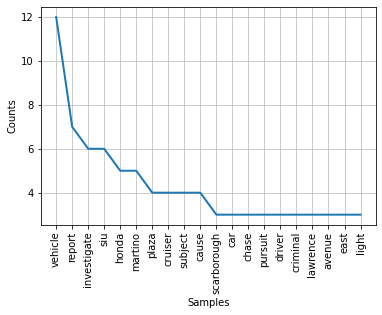

In [159]:
freq = nltk.FreqDist(tstar_articles.iloc[4,9])
for key,val in freq.items():
  print(str(key) + ':' + str(val))

freq.plot(20, cumulative=False)

# TF-IDF with sklearn

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

vectors = vectorizer.fit_transform(tstar_articles['Cleaned_Text'])
#print(vectorizer.get_feature_names()) #vocabulary
#print(vectors.shape)

feature_names = vectorizer.get_feature_names()

dense = vectors.todense()
denselist = dense.tolist()

df  = pd.DataFrame(denselist, columns=feature_names)

In [161]:
print(df)
vectors.shape #each of 147 articles is represented by 5497 features

          000  0000   01   02  0511   08  ...  zedic  zero  zip  zoia  zone  école
0    0.000000   0.0  0.0  0.0   0.0  0.0  ...    0.0   0.0  0.0   0.0   0.0    0.0
1    0.000000   0.0  0.0  0.0   0.0  0.0  ...    0.0   0.0  0.0   0.0   0.0    0.0
2    0.000000   0.0  0.0  0.0   0.0  0.0  ...    0.0   0.0  0.0   0.0   0.0    0.0
3    0.000000   0.0  0.0  0.0   0.0  0.0  ...    0.0   0.0  0.0   0.0   0.0    0.0
4    0.000000   0.0  0.0  0.0   0.0  0.0  ...    0.0   0.0  0.0   0.0   0.0    0.0
..        ...   ...  ...  ...   ...  ...  ...    ...   ...  ...   ...   ...    ...
142  0.000000   0.0  0.0  0.0   0.0  0.0  ...    0.0   0.0  0.0   0.0   0.0    0.0
143  0.032245   0.0  0.0  0.0   0.0  0.0  ...    0.0   0.0  0.0   0.0   0.0    0.0
144  0.000000   0.0  0.0  0.0   0.0  0.0  ...    0.0   0.0  0.0   0.0   0.0    0.0
145  0.013300   0.0  0.0  0.0   0.0  0.0  ...    0.0   0.0  0.0   0.0   0.0    0.0
146  0.000000   0.0  0.0  0.0   0.0  0.0  ...    0.0   0.0  0.0   0.0   0.0    0.0

[14

(147, 5497)

In [149]:
from sklearn.feature_selection import chi2
import numpy as np

tstar_articles['PortfolioId'] = portfolio_encoded
#tstar_articles.head()

portfolio_id_df = tstar_articles[['Category', 'PortfolioId']].drop_duplicates().sort_values('PortfolioId')
portfolio_to_id = dict(portfolio_id_df.values)
id_to_portfolio = dict(portfolio_id_df[['PortfolioId', 'Category']].values)

{0: 'Community Policing & Demographics', 1: 'GIS', 2: 'Missing Persons', 3: 'Overdoses & Cannabis', 4: 'Persons in Crisis', 5: 'Race-Based Data Collection', 6: 'Staffing & Workload', 7: 'Traffic', 8: 'Violent Crime'}


In [151]:
for Category, ProductId in sorted(portfolio_to_id.items()):
  features_chi2 = chi2(vectors, portfolio_encoded == ProductId)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Community Policing & Demographics':
  . Most correlated unigrams:
. metrolinx
. fight
. becerra
. pipeline
. wound
. land
. scarborough
. force
. wallenberg
. bovard
. candidate
. election
. prime
. access
. jasmine
. nuamah
. bottle
. canadian
. new
. corporate
. integrity
. aircraft
. council
. education
. suitcase
. executive
. qualify
. financial
. package
. violence
. serious
. animal
. letter
. meeting
. wet
. pedestrian
. equipment
. boy
. hospital
. scene
. montreal
. rescue
. serve
. pronounce
. federal
. tapscott
. senior
. hereditary
. snapchat
. therrien
. dog
. locate
. road
. debate
. item
. organization
. must
. tory
. mornelle
. kill
. based
. applicant
. gang
. los
. angeles
. currently
. gunshot
. approve
. canada
. night
. application
. rsu
. funding
. duraiappah
. after
. spending
. ontario
. app
. province
. hutchings
. minister
. scam
. political
. propose
. brackett
. community
. chow
. database
. dead
. homicide
. tool
. taxi
. chief
. avenue
. victim
. isca


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(tstar_articles['Cleaned_Text'])
print(tfidf.vocabulary_)
print(tfidf.idf_)
vector = tfidf.transform(tstar_articles['Cleaned_Text'])
print(vector.shape)
print(vector.toarray())


{'bloody': 644, 'gun': 2199, 'violence': 5275, 'come': 1000, 'close': 942, 'start': 4641, 'early': 1588, 'jan': 2636, 'man': 2975, 'shoot': 4430, 'oakwood': 3369, 'avenue': 510, 'vaughan': 5233, 'road': 4195, 'rush': 4231, 'trauma': 5052, 'centre': 843, 'survive': 4798, 'continue': 1123, 'last': 2789, 'day': 1291, 'double': 1534, 'shooting': 4432, 'jane': 2637, 'street': 4697, 'finch': 1922, 'west': 5364, 'hour': 2363, 'new': 3304, 'eve': 1758, 'another': 351, 'shot': 4441, 'kill': 2731, 'evening': 1761, 'two': 5099, 'victim': 5254, 'first': 1939, 'men': 3082, 'hospital': 2356, 'serious': 4375, 'condition': 1061, 'second': 4331, 'die': 1423, 'scarborough': 4286, 'neilson': 3296, 'crow': 1230, 'trail': 5030, 'east': 1593, 'people': 3588, 'injure': 2518, 'city': 912, 'previous': 3774, 'set': 4383, 'record': 4011, 'data': 1282, 'go': 2137, 'back': 520, 'despite': 1392, 'per': 3590, 'cent': 840, 'increase': 2474, 'number': 3362, 'compare': 1025, 'saw': 4280, 'seven': 4386, 'expert': 1813, 

https://towardsdatascience.com/a-complete-nlp-classification-pipeline-in-scikit-learn-bf1f2d5cdc0d

# Classification
https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [0]:
X_train, X_test, y_train, y_test = train_test_split(tstar_articles['Cleaned_Text'], tstar_articles['Category'], random_state=0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [0]:
#Encoding features
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

portfolio_encoded = le.fit_transform(tstar_articles['Category'])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecate

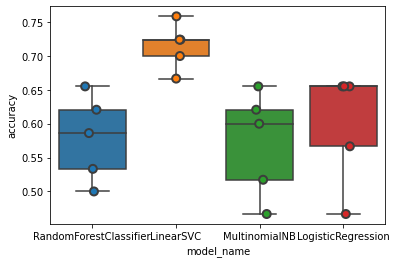

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, vectors, portfolio_encoded, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [154]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.714713
LogisticRegression        0.599770
MultinomialNB             0.571954
RandomForestClassifier    0.579080
Name: accuracy, dtype: float64

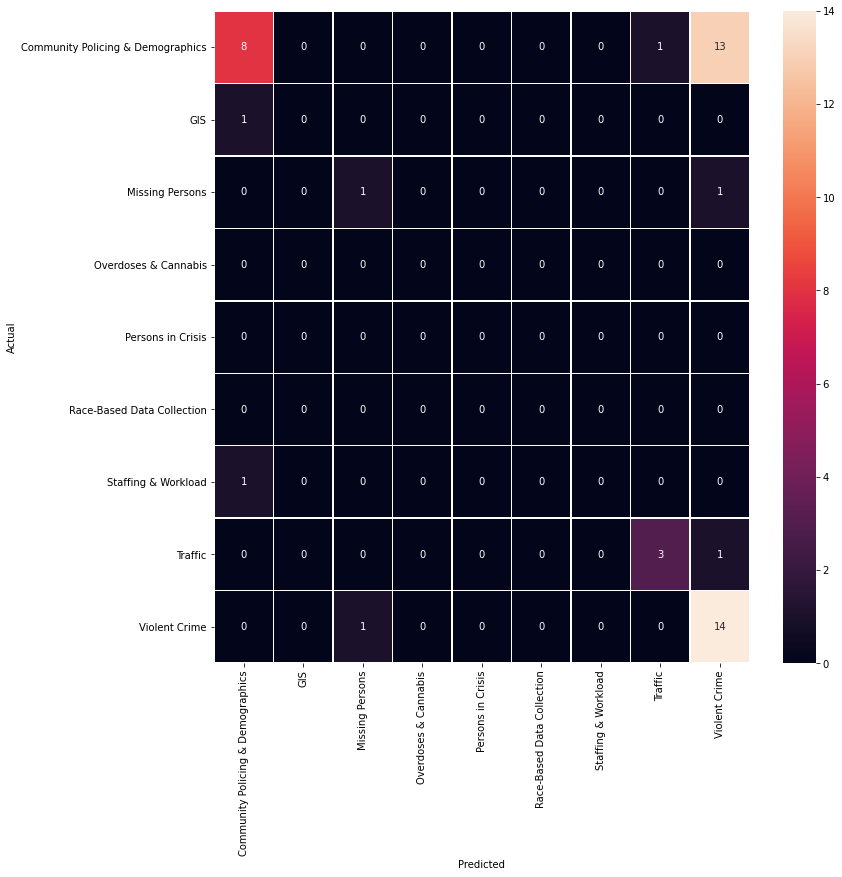

In [156]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(vectors, portfolio_encoded, tstar_articles.index, test_size=0.3, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred, labels=[0,1,2,3,4,5,6,7,8])
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=portfolio_id_df.Category.values, yticklabels=portfolio_id_df.Category.values, linewidths=.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [103]:
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
portfolio_to_id

Predicted   0  2  7   8  All
True                        
0           8  0  1  13   22
1           1  0  0   0    1
2           0  1  0   1    2
6           1  0  0   0    1
7           0  0  3   1    4
8           0  1  0  14   15
All        10  2  4  29   45


{'Community Policing & Demographics': 0,
 'GIS': 1,
 'Missing Persons': 2,
 'Overdoses & Cannabis': 3,
 'Persons in Crisis': 4,
 'Race-Based Data Collection': 5,
 'Staffing & Workload': 6,
 'Traffic': 7,
 'Violent Crime': 8}

In [112]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.80      0.36      0.50        22
           1       0.00      0.00      0.00         1
           2       0.50      0.50      0.50         2
           6       0.00      0.00      0.00         1
           7       0.75      0.75      0.75         4
           8       0.48      0.93      0.64        15

    accuracy                           0.58        45
   macro avg       0.42      0.42      0.40        45
weighted avg       0.64      0.58      0.55        45



In [158]:
model.fit(vectors, portfolio_encoded)
N = 2
import numpy as np

for Category, PortfolioId in sorted(portfolio_to_id.items()):
  indices = np.argsort(model.coef_[PortfolioId])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Community Policing & Demographics':
  . Top unigrams:
       . board
       . laser
  . Top bigrams:
       . 
# 'GIS':
  . Top unigrams:
       . use
       . ai
  . Top bigrams:
       . 
# 'Missing Persons':
  . Top unigrams:
       . richey
       . mann
  . Top bigrams:
       . 
# 'Overdoses & Cannabis':
  . Top unigrams:
       . drug
       . supervised
  . Top bigrams:
       . 
# 'Persons in Crisis':
  . Top unigrams:
       . handcuff
       . uncle
  . Top bigrams:
       . 
# 'Race-Based Data Collection':
  . Top unigrams:
       . indigenous
       . cent
  . Top bigrams:
       . 
# 'Staffing & Workload':
  . Top unigrams:
       . gazey
       . norouzian
  . Top bigrams:
       . 
# 'Traffic':
  . Top unigrams:
       . driver
       . pedestrian
  . Top bigrams:
       . 
# 'Violent Crime':
  . Top unigrams:
       . shooting
       . man
  . Top bigrams:
       . 


# TF-IDF: Rough Work

https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

In [141]:
N = len(tstar_articles['Cleaned_Text'])
N

147

In [0]:
bagOfWordsA = tstar_articles.iloc[0,6]
bagOfWordsB = tstar_articles.iloc[1,6]

In [0]:
uniqueWords = set(bagOfWordsA).union(set(bagOfWordsB))

In [21]:
uniqueWords

{'17-year-old',
 '2,300',
 '24-year-old',
 '3,100',
 '4.5-million',
 'accord',
 'accounting',
 'acknowledge',
 'across',
 'add',
 'addictive',
 'address',
 'adopt',
 'advocate',
 'alone',
 'amid',
 'among',
 'another',
 'anti-gun',
 'approach',
 'area',
 'around',
 'arrest',
 'arrive',
 'attribute',
 'avenue',
 'back',
 'bail',
 'blanket',
 'bloody',
 'boy',
 'bring',
 'buyback',
 'call',
 'care',
 'caroline',
 'cent',
 'centre',
 'chance',
 'changer.',
 'chief',
 'city',
 'close',
 'closely',
 'combined',
 'come',
 'community',
 'compare',
 'complex',
 'condition',
 'conference',
 'const',
 'continue',
 'courtney',
 'crescent',
 'crime',
 'crow',
 'data',
 'day',
 'de',
 'death',
 'decide',
 'despite',
 'die',
 'discuss',
 'divisive',
 'dominate',
 'double',
 'drug',
 'dub',
 'dy',
 'early',
 'east',
 'else',
 'emailed',
 'emphasize',
 'enforcement',
 'eve',
 'even',
 'evening',
 'exceed',
 'expert',
 'factor',
 'far',
 'fatal',
 'federal',
 'fentanyl',
 'file',
 'finch',
 'find',
 'f

In [0]:
numOfWordsA = dict.fromkeys(uniqueWords, 0)

for word in bagOfWordsA:
  numOfWordsA[word] += 1

numOfWordsB = dict.fromkeys(uniqueWords, 0)

for word in bagOfWordsB:
  numOfWordsB[word] += 1

Term Frequency Calculation

In [0]:
def computeTF(wordDict, bagOfWords):
  tfDict = {}
  bagOfWordsCount = len(bagOfWords)
  for word, count in wordDict.items():
    tfDict[word] = count / float(bagOfWordsCount)
  return tfDict

In [0]:
tfA = computeTF(numOfWordsA, bagOfWordsA)
tfB = computeTF(numOfWordsB, bagOfWordsB)

Inverse Document Frequency

In [0]:
def computeIDF(documents):
  import math
  N = len(documents)

  idfDict = dict.fromkeys(documents[0].keys(), 0)
  for document in documents:
    for word, val in document.items():
      if val > 0:
        idfDict[word] += 1

  for word, val in idfDict.items():
    idfDict[word] = math.log(N / float(val))
  return idfDict

In [0]:
idfs = computeIDF([numOfWordsA, numOfWordsB])

In [27]:
idfs

{'17-year-old': 0.6931471805599453,
 '2,300': 0.6931471805599453,
 '24-year-old': 0.6931471805599453,
 '3,100': 0.6931471805599453,
 '4.5-million': 0.6931471805599453,
 'accord': 0.6931471805599453,
 'accounting': 0.6931471805599453,
 'acknowledge': 0.6931471805599453,
 'across': 0.6931471805599453,
 'add': 0.6931471805599453,
 'addictive': 0.6931471805599453,
 'address': 0.6931471805599453,
 'adopt': 0.6931471805599453,
 'advocate': 0.6931471805599453,
 'alone': 0.6931471805599453,
 'amid': 0.6931471805599453,
 'among': 0.6931471805599453,
 'another': 0.6931471805599453,
 'anti-gun': 0.6931471805599453,
 'approach': 0.6931471805599453,
 'area': 0.6931471805599453,
 'around': 0.0,
 'arrest': 0.6931471805599453,
 'arrive': 0.6931471805599453,
 'attribute': 0.6931471805599453,
 'avenue': 0.0,
 'back': 0.6931471805599453,
 'bail': 0.6931471805599453,
 'blanket': 0.6931471805599453,
 'bloody': 0.6931471805599453,
 'boy': 0.6931471805599453,
 'bring': 0.6931471805599453,
 'buyback': 0.69314

TF-IDF Calculation

In [0]:
def computeTFIDF(tfBagOfWords, idfs):
  tfidf = {}
  for word, val in tfBagOfWords.items():
    tfidf[word] = val * idfs[word]
  return tfidf

In [29]:
tfidfA = computeTFIDF(tfA, idfs)
tfidfB = computeTFIDF(tfB, idfs)
tfdf = pd.DataFrame([tfidfA, tfidfB])
tfdf

,mayor,adopt,4.5-million,line,november,scarborough,amid,data,together,lot,boy,law,tough,chief,conference,set,like,care,file,one,hospital,live,second,number,blanket,bloody,spike,street,city,"3,100",fentanyl,around,east,project,forty-three,plan,intelligence,particularly,among,partially,...,glen,gang,add,victim,factor,dominate,strategic,neilson,shoot,two,crescent,combined,hour,trauma,news,seizure,wrap,morning,early,kloet,arrive,injury,health,trade,survive,total,dub,increase,crime,address,drug,24-year-old,shooting,good,dy,rush,homicide,need,front,per
0,0.011144,0.002229,0.002229,0.002229,0.002229,0.002229,0.002229,0.002229,0.002229,0.002229,0.000000,0.002229,0.002229,0.004458,0.002229,0.004458,0.002229,0.002229,0.002229,0.0,0.0,0.002229,0.0,0.002229,0.002229,0.002229,0.002229,0.0,0.011144,0.002229,0.002229,0.0,0.002229,0.008915,0.002229,0.002229,0.002229,0.002229,0.002229,0.002229,...,0.004458,0.004458,0.002229,0.0,0.002229,0.002229,0.004458,0.002229,0.006686,0.002229,0.000000,0.002229,0.002229,0.002229,0.002229,0.002229,0.002229,0.000000,0.0,0.000000,0.000000,0.0,0.002229,0.002229,0.002229,0.004458,0.002229,0.004458,0.002229,0.006686,0.002229,0.000000,0.0,0.002229,0.002229,0.0,0.004458,0.002229,0.002229,0.002229
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014441,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014441,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014441,0.0,0.014441,0.014441,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014441,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
